In [2]:
! pip install pyspark

In [3]:
! pip install sparknlp

In [4]:
import sparknlp
spark = sparknlp.start() 
# sparknlp.start(gpu=True) >> for training on GPU

:: loading settings :: url = jar:file:/opt/anaconda3/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/gideontesfai/.ivy2/cache
The jars for the packages stored in: /Users/gideontesfai/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-12d0b1cc-6ec4-4ea8-a4a6-5f22c1dc7766;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.2.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.pro

22/12/06 05:07:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
df = spark.read.format("csv").option("header", True).option("multiline", True).option("escape", "\"").load("train.csv")

In [6]:
df.show()

+---+--------------------+--------------------+--------------------+-----+
| id|               title|              author|                text|label|
+---+--------------------+--------------------+--------------------+-----+
|  0|House Dem Aide: W...|       Darrell Lucus|House Dem Aide: W...|    1|
|  1|FLYNN: Hillary Cl...|     Daniel J. Flynn|Ever get the feel...|    0|
|  2|Why the Truth Mig...|  Consortiumnews.com|Why the Truth Mig...|    1|
|  3|15 Civilians Kill...|     Jessica Purkiss|Videos 15 Civilia...|    1|
|  4|Iranian woman jai...|      Howard Portnoy|Print \nAn Irania...|    1|
|  5|Jackie Mason: Hol...|     Daniel Nussbaum|In these trying t...|    0|
|  6|Life: Life Of Lux...|                 nan|Ever wonder how B...|    1|
|  7|Benoît Hamon Wins...|     Alissa J. Rubin|PARIS  —   France...|    0|
|  8|Excerpts From a D...|                 nan|Donald J. Trump i...|    0|
|  9|A Back-Channel Pl...|Megan Twohey and ...|A week before Mic...|    0|
| 10|Obama’s Organizin...

In [7]:
# Expanding contractions and lowering
from pyspark.sql.functions import lower, regexp_replace

replacement_patterns = [
  (r'won\'t', 'will not'),
  (r'can\'t', 'cannot'),
  (r'i\'m', 'i am'),
  (r'ain\'t', 'is not'),
  (r'(\w+)\'ll', '\g<1> will'),
  (r'(\w+)n\'t', '\g<1> not'),
  (r'(\w+)\'ve', '\g<1> have'),
  (r'(\w+)\'s', '\g<1> is'),
  (r'(\w+)\'re', '\g<1> are'),
  (r'(\w+)\'d', '\g<1> would')
]

# create a copy
df_clean = df.alias('df_clean')

for (pattern, repl) in replacement_patterns:
  df_clean = df_clean.select('id', 
          (lower(regexp_replace('text', pattern, repl)).alias('text')), 
          (lower(regexp_replace('title', pattern, repl)).alias('title')),
          'label')

df_clean.show()

+---+--------------------+--------------------+-----+
| id|                text|               title|label|
+---+--------------------+--------------------+-----+
|  0|house dem aide: w...|house dem aide: w...|    1|
|  1|ever get the feel...|flynn: hillary cl...|    0|
|  2|why the truth mig...|why the truth mig...|    1|
|  3|videos 15 civilia...|15 civilians kill...|    1|
|  4|print \nan irania...|iranian woman jai...|    1|
|  5|in these trying t...|jackie mason: hol...|    0|
|  6|ever wonder how b...|life: life of lux...|    1|
|  7|paris  —   france...|benoît hamon wins...|    0|
|  8|donald j. trump i...|excerpts from a d...|    0|
|  9|a week before mic...|a back-channel pl...|    0|
| 10|organizing for ac...|obama’s organizin...|    0|
| 11|the bbc produced ...|bbc comedy sketch...|    0|
| 12|the mystery surro...|russian researche...|    1|
| 13|clinton campaign ...|us officials see ...|    1|
| 14|yes, there are pa...|re: yes, there ar...|    1|
| 15|guillermo barros ...|in

In [8]:
# Removing puntuation and digits
df_clean = df_clean.select('id', 
                     (regexp_replace('text', "[^a-z\\s]", "").alias('text')),
                     (regexp_replace('title', "[^a-z\\s]", "").alias('title')),
                     'label')

# Removing extra spaces
df_clean = df_clean.select('id', 
                     (regexp_replace('text', r'\s+', " ").alias('text')),
                     (regexp_replace('title', r'\s+', " ").alias('title')),
                     'label')

In [9]:
from pyspark.ml.feature import Tokenizer

# Tokenize text
tokenizer_text = Tokenizer(inputCol='text', outputCol='text_tokens')
tokenizer_title = Tokenizer(inputCol='title', outputCol='title_tokens')

df_tokenized = tokenizer_text.transform(df_clean).select('title', 'text_tokens', 'label')
df_tokenized = tokenizer_title.transform(df_tokenized).select('title_tokens', 'text_tokens', 'label')


In [10]:
df_tokenized.show()

+--------------------+--------------------+-----+
|        title_tokens|         text_tokens|label|
+--------------------+--------------------+-----+
|[house, dem, aide...|[house, dem, aide...|    1|
|[flynn, hillary, ...|[ever, get, the, ...|    0|
|[why, the, truth,...|[why, the, truth,...|    1|
|[, civilians, kil...|[videos, civilian...|    1|
|[iranian, woman, ...|[print, an, irani...|    1|
|[jackie, mason, h...|[in, these, tryin...|    0|
|[life, life, of, ...|[ever, wonder, ho...|    1|
|[benot, hamon, wi...|[paris, france, c...|    0|
|[excerpts, from, ...|[donald, j, trump...|    0|
|[a, backchannel, ...|[a, week, before,...|    0|
|[obamas, organizi...|[organizing, for,...|    0|
|[bbc, comedy, ske...|[the, bbc, produc...|    0|
|[russian, researc...|[the, mystery, su...|    1|
|[us, officials, s...|[clinton, campaig...|    1|
|[re, yes, there, ...|[yes, there, are,...|    1|
|[in, major, leagu...|[guillermo, barro...|    0|
|[wells, fargo, ch...|[the, scandal, en...|    0|


In [11]:
# Remove stop words
from pyspark.ml.feature import StopWordsRemover

remover_text = StopWordsRemover(inputCol='text_tokens', outputCol='text_tokens_clean')
remover_title = StopWordsRemover(inputCol='title_tokens', outputCol='title_tokens_clean')

df_no_stopw = remover_text.transform(df_tokenized).select('title_tokens', 'text_tokens_clean', 'label')
df_no_stopw = remover_title.transform(df_no_stopw).select('title_tokens_clean', 'text_tokens_clean', 'label')

In [12]:
df_no_stopw.show()

+--------------------+--------------------+-----+
|  title_tokens_clean|   text_tokens_clean|label|
+--------------------+--------------------+-----+
|[house, dem, aide...|[house, dem, aide...|    1|
|[flynn, hillary, ...|[ever, get, feeli...|    0|
|[truth, might, ge...|[truth, might, ge...|    1|
|[, civilians, kil...|[videos, civilian...|    1|
|[iranian, woman, ...|[print, iranian, ...|    1|
|[jackie, mason, h...|[trying, times, j...|    0|
|[life, life, luxu...|[ever, wonder, br...|    1|
|[benot, hamon, wi...|[paris, france, c...|    0|
|[excerpts, draft,...|[donald, j, trump...|    0|
|[backchannel, pla...|[week, michael, f...|    0|
|[obamas, organizi...|[organizing, acti...|    0|
|[bbc, comedy, ske...|[bbc, produced, s...|    0|
|[russian, researc...|[mystery, surroun...|    1|
|[us, officials, s...|[clinton, campaig...|    1|
|[re, yes, paid, g...|[yes, paid, gover...|    1|
|[major, league, s...|[guillermo, barro...|    0|
|[wells, fargo, ch...|[scandal, engulfi...|    0|


In [13]:
# Here is your code

In [14]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import string
import collections
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [15]:
# Creating a word cloud for all articles that have a label ==1 
df = pd.read_csv('train.csv')
label1=df[df.label==1]
print(label1.shape)

(10413, 5)


Text(0.5, 0, 'Labels')

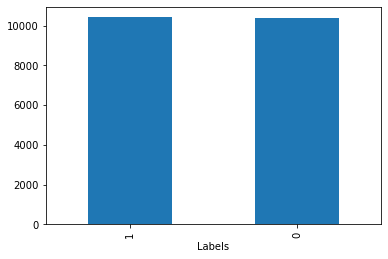

In [16]:
import matplotlib.pyplot as plt

#plot distribution of points by team 
df['label'].value_counts().plot(kind='bar')

#add x-axis label
plt.xlabel('Labels')

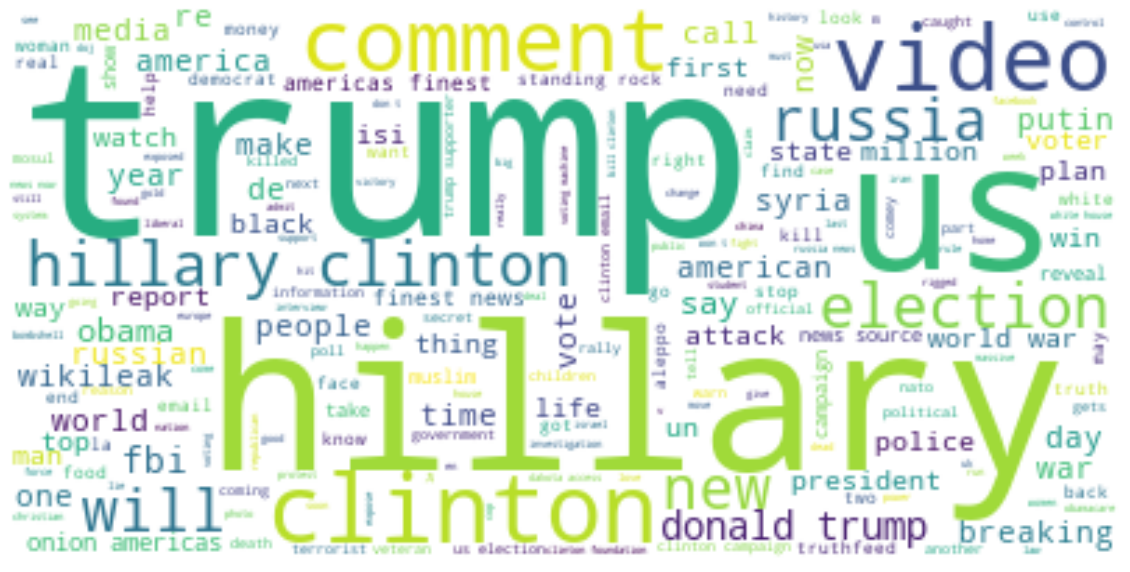

In [20]:
# Converting title to lower case
label1["title"]=label1["title"].str.lower()

# taking the panctuations out of the text 
all_label=label1["title"].str.split(' ')
all_label.head()

all_title_cleaned=[]
for text in all_label:
    text=[x.strip(string.punctuation) for x in str(text)]
    all_title_cleaned.append(text)

all_title_cleaned[0]

title_label=[''.join(text) for text in all_title_cleaned]
final_title_label=" ".join(title_label)
final_title_label[:500]

#Word cloud for label 1 
stopwords=set(STOPWORDS)
stopwords.update(["s","nan",'u'])
wordcloud_spam= WordCloud(stopwords=stopwords,background_color="white").generate(final_title_label)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

(10387, 5)


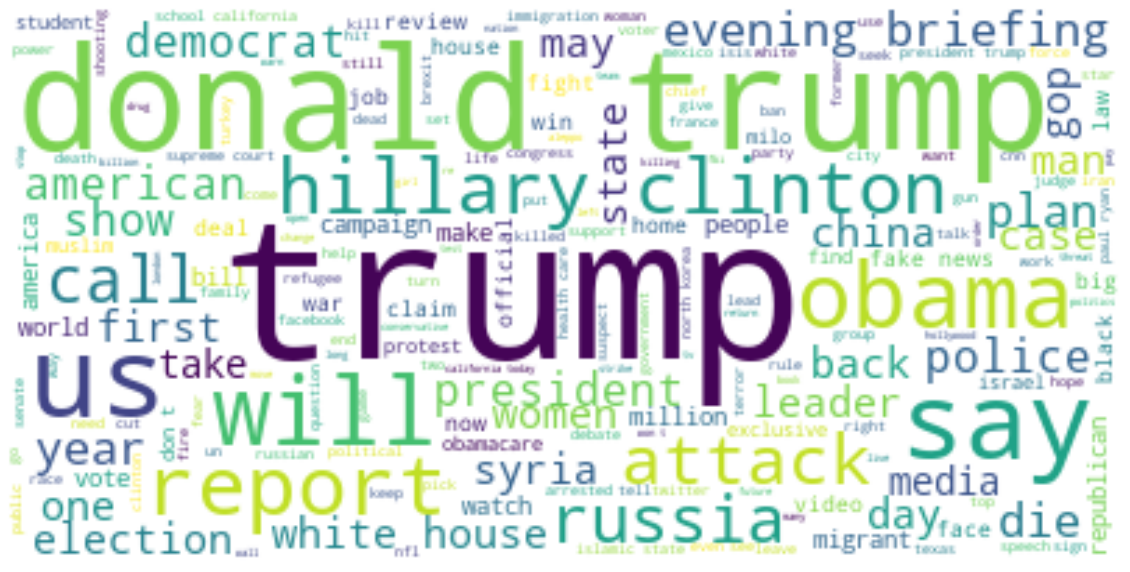

In [22]:
# Creating a word cloud for all articles that have a label ==1 
df = pd.read_csv('train.csv')
label1=df[df.label==0]
print(label1.shape)
# Converting title to lower case
label0["title"]=label1["title"].str.lower()

# taking the panctuations out of the text 
all_label=label0["title"].str.split(' ')

all_title_cleaned=[]
for text in all_label:
    text=[x.strip(string.punctuation) for x in str(text)]
    all_title_cleaned.append(text)

all_title_cleaned[0]

title_label=[''.join(text) for text in all_title_cleaned]
final_title_label=" ".join(title_label)
final_title_label[:500]

#Word cloud for label 1 
stopwords=set(STOPWORDS)
stopwords.update(["s","nan",'u',"new york","york","breitbart","time","new","times"])
wordcloud_spam= WordCloud(stopwords=stopwords,background_color="white").generate(final_title_label)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

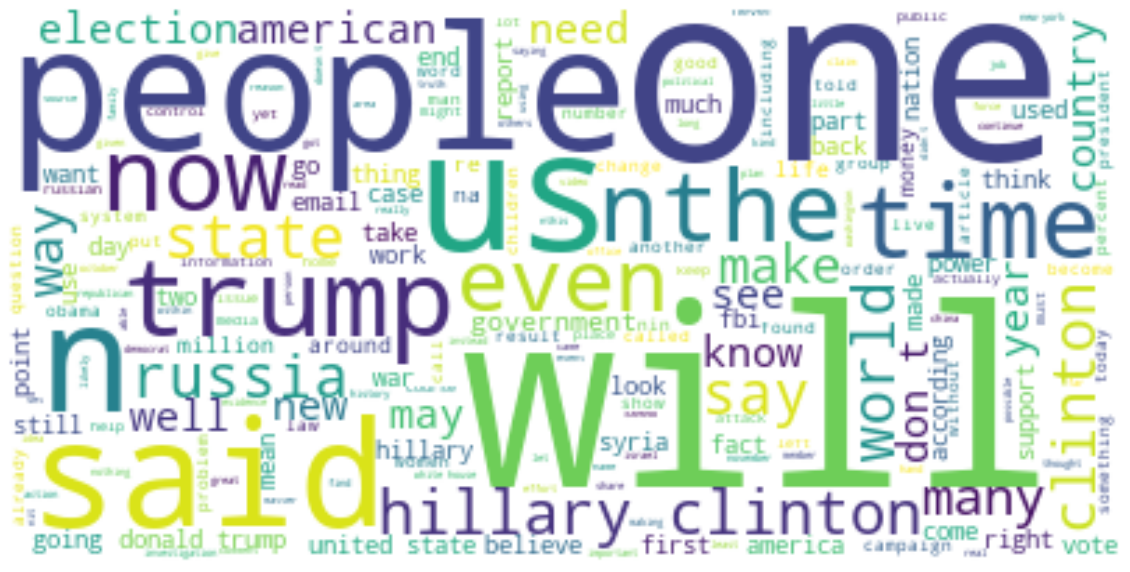

In [21]:

# Creating a word cloud for all articles that have a label ==1 
label1=df[df.label==1]

# Converting text to lower case
label1["text"]=label1["text"].str.lower()

# taking the panctuations out of the text 
all_label=label1["text"].str.split(' ')
all_label.head()

all_title_cleaned=[]
for text in all_label:
    text=[x.strip(string.punctuation) for x in str(text)]
    all_title_cleaned.append(text)

all_title_cleaned[0]

title_label=[''.join(text) for text in all_title_cleaned]
final_title_label=" ".join(title_label)
final_title_label[:500]

#Word cloud for label 1 
stopwords=set(STOPWORDS)
stopwords.update(["s","nan",'u'])
wordcloud_spam= WordCloud(stopwords=stopwords,background_color="white").generate(final_title_label)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

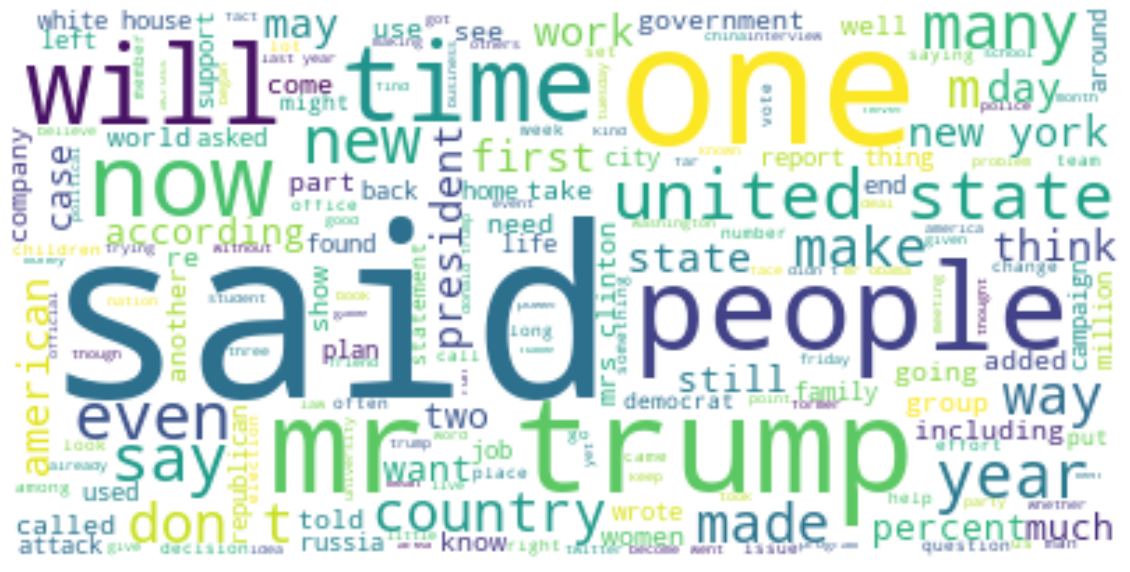

In [24]:

# Creating a word cloud for all articles that have a label ==1 
label1=df[df.label==0]

# Converting text to lower case
label1["text"]=label1["text"].str.lower()

# taking the panctuations out of the text 
all_label=label1["text"].str.split(' ')
all_label.head()

all_title_cleaned=[]
for text in all_label:
    text=[x.strip(string.punctuation) for x in str(text)]
    all_title_cleaned.append(text)

all_title_cleaned[0]

title_label=[''.join(text) for text in all_title_cleaned]
final_title_label=" ".join(title_label)
final_title_label[:500]

#Word cloud for label 1 
stopwords=set(STOPWORDS)
stopwords.update(["s","nan",'u'])
wordcloud_spam= WordCloud(stopwords=stopwords,background_color="white").generate(final_title_label)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()